In [17]:
import matplotlib.pyplot as plt

import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import math

# Core jax
import jax
# from jax.config import config
# from jax import Array, vmap

import jax.numpy as jnp
import jax.random as jr
import numpy as np
import equinox as eqx
# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'false'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

# This was made using Connor's help - I think it's mostly a direct copy of code he already has in his repo.
phase_mask = np.load("/Users/angusrutherford/Desktop/dLuxToliman/new_diffractive_pupil.npy")

mask = dl.Optic(phase=phase_mask)

wavefront_npix = 2000 # 2000 # Wavefront number of pixels
aperture_diam = 0.125 # Diameter of aperture (m)
oversample = 1
coords = dlu.pixel_coords(wavefront_npix * oversample, aperture_diam)
secondary_diam = 0.032 # Diameter of secondary mirror (m)
spider_width = 0.002 # Spider width (m)
psf_npixels = 256 #3600 # Number of pixels across one axis on detector
pixel_scale = 0.375 # Converting angle between binary source to angle on detector
primary = dlu.circle(coords, aperture_diam/2)
secondary = dlu.circle(coords, secondary_diam/2, invert=True)
angles = [0, 120, 240]
spiders = dlu.spider(coords, spider_width, angles)

aperture = dlu.combine([primary, secondary, spiders], oversample)

# Define the optical layers
layers = [("aperture", dl.layers.Optic(aperture, normalise=True)), ("phase_mask", mask)]

# Construct the optics object
# optics = dl.AngularOpticalSystem(wavefront_npix, aperture_diam, layers, psf_npixels, pixel_scale, oversample)
optics = dlT.TolimanOpticalSystem(
    wavefront_npix,
    psf_npixels,
    oversample,
    pixel_scale,
    mask=mask,
    radial_orders=[6]
    )

# Build a source
source = dlT.AlphaCen(
    n_wavels=3,
    separation=10.0,
    position_angle=90,
    x_position=0,
    y_position=0,
    log_flux=6.832,
    contrast=3.37,
    bandpass=(530, 640),
    weights=None
)

instrument = dlT.Toliman(optics, source)

psf = instrument.model()

In [12]:
import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates
import numpyro.distributions as dist
from tqdm import tqdm

def generate_distorted_grid(psf_npixels: int,
                            pixel_scale: float,
                            shift_mean_x: float = 0.0,
                            shift_mean_y: float = 0.0,
                            shift_std: float = 0.0,
                            pDistort: float = 1.0,                   # NEW
                            key: jax.random.PRNGKey = None,
                            noise_field_x: jnp.ndarray = None,
                            noise_field_y: jnp.ndarray = None):
    """
    Creates a distorted grid by shifting each pixel's (x, y) coordinate.

    Args:
      psf_npixels: Size of the PSF array (e.g. 256).
      pixel_scale: Arcsec per pixel.
      shift_mean_x, shift_mean_y: Mean shift (arcsec).
      shift_std: Std dev of random jitter (arcsec).
      pDistort: Fraction of pixels that actually get the random jitter [0..1].
      key: A JAX PRNGKey. Required if pDistort is between 0 and 1, because
           we need to sample a Bernoulli mask. If None, we assume either 
           pDistort=0 or 1, or you supply precomputed noise fields that you
           want to apply to all pixels.
      noise_field_x, noise_field_y: Fixed noise fields of shape 
           (psf_npixels, psf_npixels). If these are provided (and key=None),
           then the shifts will be exactly the same on every call.

    Returns:
      (distorted_grid_x, distorted_grid_y): 2D arrays of x- and y-coordinates
      in physical units (arcsec), with the desired pixel-level distortions.

    Raises:
      ValueError: If shift_std != 0 but neither a key nor noise fields are given.
                  Or if pDistort in (0,1) but no key is given.
    """

    # Create the base grid in arcseconds
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1) / 2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)  # "xy" indexing

    if shift_std != 0.0:
        # We need random offsets from Normal(0, shift_std).
        if key is not None:
            # Generate a random noise field
            noise_x = jax.random.normal(key, shape=(psf_npixels, psf_npixels))
            key, subkey = jax.random.split(key)
            noise_y = jax.random.normal(subkey, shape=(psf_npixels, psf_npixels))

            # Create a mask for partial distortion
            if pDistort == 1.0:
                mask = jnp.ones_like(noise_x)
            elif pDistort == 0.0:
                mask = jnp.zeros_like(noise_x)
            else:
                # pDistort in (0,1) => sample a Bernoulli mask
                key, subkey = jax.random.split(key)
                mask = jax.random.bernoulli(subkey, pDistort, shape=noise_x.shape)

        elif (noise_field_x is not None) and (noise_field_y is not None):
            # Use the fixed noise fields
            noise_x = noise_field_x
            noise_y = noise_field_y

            # If no key is given, we can only do pDistort=0 or 1.
            if pDistort == 1.0:
                mask = jnp.ones_like(noise_x)
            elif pDistort == 0.0:
                mask = jnp.zeros_like(noise_x)
            else:
                raise ValueError(
                    "pDistort is between 0 and 1, but no key was provided. "
                    "We can't randomly choose which pixels get distorted without a PRNG key. "
                    "If you want deterministic partial distortion, implement a custom mask."
                )

        else:
            # shift_std != 0 but we have no way to generate or supply random fields
            raise ValueError("When shift_std != 0, supply a key or noise_field arrays.")

        # Apply the random offsets scaled by mask
        shift_x_arr = shift_mean_x + shift_std * noise_x * mask
        shift_y_arr = shift_mean_y + shift_std * noise_y * mask

    else:
        # If shift_std=0, there's no random offset
        shift_x_arr = jnp.full((psf_npixels, psf_npixels), shift_mean_x)
        shift_y_arr = jnp.full((psf_npixels, psf_npixels), shift_mean_y)

    # By convention, positive shift_mean_y moves the PSF 'up' => subtract from Y
    distorted_grid_x = grid_x - shift_x_arr
    distorted_grid_y = grid_y - shift_y_arr

    return distorted_grid_x, distorted_grid_y

def physical_to_indices(grid_x: jnp.ndarray, grid_y: jnp.ndarray,
                        nsamples: int, pixel_scale: float) -> jnp.ndarray:
    center = (nsamples - 1) / 2.0
    # Here we assume: row = center - (y/pixel_scale) and col = center + (x/pixel_scale)
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf: jnp.ndarray,
                                 grid_x: jnp.ndarray,
                                 grid_y: jnp.ndarray,
                                 pixel_scale: float) -> jnp.ndarray:
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')

def get_fixed_noise_fields(psf_npixels: int, seed: int = 123):
    key = jax.random.PRNGKey(seed)
    noise_field_x = jax.random.normal(key, shape=(psf_npixels, psf_npixels))
    key, subkey = jax.random.split(key)
    noise_field_y = jax.random.normal(subkey, shape=(psf_npixels, psf_npixels))
    return noise_field_x, noise_field_y

# --- Simple configurable MH Sampler ---
def fit_distortion(free_params: dict, fixed_params: dict, num_iters: int,
                   proposal_std: float, psf, observed_psf, psf_npixels: int,
                   pixel_scale: float, sigma: float, noise_field_x, noise_field_y, seed=0):
    """
    free_params: dictionary of free parameter initial guesses (e.g. {"shift_mean_y": 0.0})
    fixed_params: dictionary of fixed parameters (e.g. {"shift_mean_x": 2.0, "shift_std": 1.0})
    
    This function runs a basic Metropolis–Hastings sampler on the free parameters only.
    It prints and returns the posterior means for the free parameters.
    """
    # Create a sorted list of keys for free parameters.
    free_keys = sorted(free_params.keys())
    # Convert free_params dict to vector (in sorted order)
    init_vector = jnp.array([free_params[k] for k in free_keys])
    
    def combine_params(free_vector):
        combined = fixed_params.copy()
        for i, key in enumerate(free_keys):
            combined[key] = free_vector[i]
        return combined

    def log_prob_fn(free_vector):
        params = combine_params(free_vector)
        # Enforce nonnegative shift_std if it is one of the parameters.
        if "shift_std" in params and params["shift_std"] < 0:
            return -jnp.inf
        grid_x, grid_y = generate_distorted_grid(
            psf_npixels, pixel_scale,
            shift_mean_x=params.get("shift_mean_x", 0.0),
            shift_mean_y=params.get("shift_mean_y", 0.0),
            shift_std=params.get("shift_std", 0.0),
            key=None,
            noise_field_x=noise_field_x,
            noise_field_y=noise_field_y
        )
        predicted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        log_like = -0.5 * jnp.sum(((predicted_psf - observed_psf) ** 2) / (sigma ** 2))
        lp = log_like
        if "shift_mean_x" in params:
            lp += dist.Normal(0.0, 10.0).log_prob(params["shift_mean_x"])
        if "shift_mean_y" in params:
            lp += dist.Normal(0.0, 10.0).log_prob(params["shift_mean_y"])
        if "shift_std" in params:
            lp += dist.HalfNormal(10.0).log_prob(params["shift_std"])
        return lp

    key = jax.random.PRNGKey(seed)
    current = init_vector
    current_lp = log_prob_fn(current)
    samples = [current]
    for i in tqdm(range(num_iters), desc="MH Sampling"):
        key, subkey = jax.random.split(key)
        proposal = current + proposal_std * jax.random.normal(subkey, shape=current.shape)
        proposal_lp = log_prob_fn(proposal)
        key, subkey = jax.random.split(key)
        u = jax.random.uniform(subkey)
        if jnp.log(u) < (proposal_lp - current_lp):
            current = proposal
            current_lp = proposal_lp
        samples.append(current)
    samples = jnp.array(samples)
    posterior_mean = jnp.mean(samples, axis=0)
    result = {k: float(posterior_mean[i]) for i, k in enumerate(free_keys)}
    formatted_result = ", ".join(f"{k} = {v:.6f}" for k, v in sorted(result.items()))
    print("Posterior means:", formatted_result)
    return samples, result

# --- Usage Example ---
# Assume 'psf' is your ideal PSF (JAX array of shape (256,256)).
# And 'observed_psf' is your ground-truth distorted PSF.
psf_npixels = 256
pixel_scale = 0.375
sigma = 1.0
key = jax.random.PRNGKey(123)
pDistort = 0.25

# Ground truth parameters for observed PSF:
true_params = {"shift_mean_x": 0, "shift_mean_y": 0, "shift_std": 0.01 * pixel_scale}
noise_field_x, noise_field_y = get_fixed_noise_fields(psf_npixels, seed=123)
grid_x, grid_y = generate_distorted_grid(psf_npixels, pixel_scale,
                                          shift_mean_x=true_params["shift_mean_x"],
                                          shift_mean_y=true_params["shift_mean_y"],
                                          shift_std=true_params["shift_std"],
                                          key=key,
                                          pDistort=pDistort,
                                          noise_field_x=noise_field_x,
                                          noise_field_y=noise_field_y)
distorted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)



In [20]:
import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates
import optax
import numpy as np
import matplotlib.pyplot as plt

def physical_to_indices(grid_x: jnp.ndarray, grid_y: jnp.ndarray, nsamples: int, pixel_scale: float) -> jnp.ndarray:
    center = (nsamples - 1) / 2.0
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf: jnp.ndarray, grid_x: jnp.ndarray, grid_y: jnp.ndarray, pixel_scale: float) -> jnp.ndarray:
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')

def get_fixed_noise_fields(psf_npixels: int, seed: int = 123):
    key = jax.random.PRNGKey(seed)
    noise_field_x = jax.random.normal(key, shape=(psf_npixels, psf_npixels))
    key, subkey = jax.random.split(key)
    noise_field_y = jax.random.normal(subkey, shape=(psf_npixels, psf_npixels))
    return noise_field_x, noise_field_y

def generate_distorted_grid(psf_npixels: int,
                            pixel_scale: float,
                            shift_mean_x: float = 0.0,
                            shift_mean_y: float = 0.0,
                            shift_std: float = 0.0,
                            pDistort: float = 1.0,
                            key: jax.random.PRNGKey = None,
                            noise_field_x: jnp.ndarray = None,
                            noise_field_y: jnp.ndarray = None):
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1) / 2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)
    
    if shift_std != 0.0:
        if key is not None:
            noise_x = jax.random.normal(key, shape=(psf_npixels, psf_npixels))
            key, subkey = jax.random.split(key)
            noise_y = jax.random.normal(subkey, shape=(psf_npixels, psf_npixels))
            
            if pDistort == 1.0:
                mask = jnp.ones_like(noise_x)
            elif pDistort == 0.0:
                mask = jnp.zeros_like(noise_x)
            else:
                key, subkey = jax.random.split(key)
                mask = jax.random.bernoulli(subkey, pDistort, shape=noise_x.shape)
        
        elif (noise_field_x is not None) and (noise_field_y is not None):
            noise_x = noise_field_x
            noise_y = noise_field_y
            
            if pDistort == 1.0:
                mask = jnp.ones_like(noise_x)
            elif pDistort == 0.0:
                mask = jnp.zeros_like(noise_x)
            else:
                raise ValueError("pDistort is between 0 and 1, but no key provided.")
        else:
            raise ValueError("When shift_std != 0, supply a key or noise_field arrays.")
        
        shift_x_arr = shift_mean_x + shift_std * noise_x * mask
        shift_y_arr = shift_mean_y + shift_std * noise_y * mask
    else:
        shift_x_arr = jnp.full((psf_npixels, psf_npixels), shift_mean_x)
        shift_y_arr = jnp.full((psf_npixels, psf_npixels), shift_mean_y)
    
    distorted_grid_x = grid_x - shift_x_arr
    distorted_grid_y = grid_y - shift_y_arr
    
    return distorted_grid_x, distorted_grid_y

def run_psf_shift_recovery(psf):
    # Simulation Parameters
    psf_npixels = psf.shape[0]
    pixel_scale = 0.375  # arcsec per pixel

    # Simulate true distortion parameters
    true_shift_std = 0.01 * pixel_scale  # ~1/100th of a pixel
    key = jax.random.PRNGKey(123)
    noise_field_x, noise_field_y = get_fixed_noise_fields(psf_npixels, seed=123)
    pDistort = 1  # fraction of pixels distorted

    # Generate the observed distorted grid with true shifts
    distorted_grid_x, distorted_grid_y = generate_distorted_grid(
        psf_npixels, pixel_scale,
        shift_mean_x=0.0,
        shift_mean_y=0.0,
        shift_std=true_shift_std,
        pDistort=pDistort,
        key=key,
        noise_field_x=noise_field_x,
        noise_field_y=noise_field_y
    )

    # Generate the observed distorted PSF
    observed_distorted_psf = sample_psf_on_distorted_grid(psf, distorted_grid_x, distorted_grid_y, pixel_scale)

    # Compute the ideal grid (physical coordinates)
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1) / 2) * pixel_scale
    ideal_grid_x, ideal_grid_y = jnp.meshgrid(centers, centers)

    # Initialize parameters with random noise close to expected distribution
    init_params = {
        "shift_x": true_shift_std * jax.random.normal(jax.random.PRNGKey(0), shape=(psf_npixels, psf_npixels)),
        "shift_y": true_shift_std * jax.random.normal(jax.random.PRNGKey(1), shape=(psf_npixels, psf_npixels))
    }

    # Define the forward model
    def model_fn(params):
        sim_grid_x = ideal_grid_x - params["shift_x"]
        sim_grid_y = ideal_grid_y - params["shift_y"]
        simulated_psf = sample_psf_on_distorted_grid(psf, sim_grid_x, sim_grid_y, pixel_scale)
        return simulated_psf

    # Enhanced loss function with stronger constraints
    def loss_fn(params):
        simulated_psf = model_fn(params)
        
        # PSF difference loss
        psf_loss = jnp.mean((simulated_psf - observed_distorted_psf) ** 2)
        
        # Stronger regularization using original noise fields
        shift_penalty_x = jnp.mean(jnp.abs(params["shift_x"] - true_shift_std * noise_field_x)**2)
        shift_penalty_y = jnp.mean(jnp.abs(params["shift_y"] - true_shift_std * noise_field_y)**2)
        
        # Combine losses with aggressive weighting
        total_loss = psf_loss + 10.0 * (shift_penalty_x + shift_penalty_y)
        
        return total_loss

    # Learning rate scheduler
    scheduler = optax.exponential_decay(
        init_value=1e-3, 
        transition_steps=1000, 
        decay_rate=0.9
    )
    optimizer = optax.adam(scheduler)
    opt_state = optimizer.init(init_params)

    # Optimization loop with debugging
    def print_debug_info(params, i):
        if i % 500 == 0:
            shift_x_norm = jnp.linalg.norm(params["shift_x"])
            shift_y_norm = jnp.linalg.norm(params["shift_y"])
            print(f"Step {i}, Shift X Norm: {shift_x_norm}, Shift Y Norm: {shift_y_norm}")

    @jax.jit
    def step(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        
        # Gradient clipping with wider range
        grads = jax.tree_map(lambda g: jnp.clip(g, -1.0, 1.0), grads)
        
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    # Run optimization
    n_steps = 20000
    params = init_params
    losses = []

    for i in range(n_steps):
        params, opt_state, loss_value = step(params, opt_state)
        print_debug_info(params, i)
        
        if i % 500 == 0:
            losses.append(loss_value)

    # Retrieve recovered per-pixel shifts
    recovered_shift_x = params["shift_x"]
    recovered_shift_y = params["shift_y"]

    # Compute true shifts: true_shift = ideal_grid - distorted_grid
    true_shift_x = ideal_grid_x - distorted_grid_x
    true_shift_y = ideal_grid_y - distorted_grid_y

    # Evaluate the recovery accuracy
    error_x = jnp.mean(jnp.abs(recovered_shift_x - true_shift_x))
    error_y = jnp.mean(jnp.abs(recovered_shift_y - true_shift_y))
    print("Mean absolute error in shift_x (arcsec):", error_x)
    print("Mean absolute error in shift_y (arcsec):", error_y)

    # Visualization of shifts
    plt.figure(figsize=(15,5))
    
    plt.subplot(131)
    plt.title('True Shifts X')
    plt.imshow(true_shift_x, cmap='coolwarm')
    plt.colorbar()
    
    plt.subplot(132)
    plt.title('Recovered Shifts X')
    plt.imshow(recovered_shift_x, cmap='coolwarm')
    plt.colorbar()
    
    plt.subplot(133)
    plt.title('Shift X Difference')
    plt.imshow(recovered_shift_x - true_shift_x, cmap='coolwarm')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

    # Plot loss progression
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.title('Loss Progression')
    plt.xlabel('Logging Interval')
    plt.ylabel('Loss')
    plt.show()

    return recovered_shift_x, recovered_shift_y, true_shift_x, true_shift_y

# Note: You'll need to provide the 'psf' variable before calling this function
recovered_x, recovered_y, true_x, true_y = run_psf_shift_recovery(psf)



Step 0, Shift X Norm: 0.8755857348442078, Shift Y Norm: 0.87372225522995
Step 500, Shift X Norm: 1.041817545890808, Shift Y Norm: 1.099594235420227
Step 1000, Shift X Norm: 1.0384443998336792, Shift Y Norm: 1.1057871580123901
Step 1500, Shift X Norm: 1.0373880863189697, Shift Y Norm: 1.1042872667312622


KeyboardInterrupt: 

In [5]:
def hhmm_to_minutes(hhmm):
    """Convert an integer like 937 (9:37 AM) to the total number of minutes after midnight."""
    if not isinstance(hhmm, int):
        raise ValueError("Time should be an integer in HHMM format.")
    if hhmm < 0 or hhmm > 2359:
        raise ValueError("Times must be between 0 and 2359 in HHMM format.")

    hours = hhmm // 100
    mins = hhmm % 100

    if mins >= 60:
        raise ValueError("Minutes should be 0–59 in HHMM format.")

    return hours * 60 + mins

def calc_hours_worked(start_time, lunch_start_time, lunch_end_time, end_time):
    # Convert each HHMM integer to total minutes
    start_minutes      = hhmm_to_minutes(start_time)
    lunch_start_mins   = hhmm_to_minutes(lunch_start_time)
    lunch_end_mins     = hhmm_to_minutes(lunch_end_time)
    end_minutes        = hhmm_to_minutes(end_time)

    # Ensure times make sense (e.g., lunch start is after start, lunch end is after lunch start, etc.)
    if not (start_minutes <= lunch_start_mins <= lunch_end_mins <= end_minutes):
        raise ValueError("The chronological order of times is invalid.")

    # Calculate minutes before lunch and after lunch
    before_lunch = lunch_start_mins - start_minutes
    after_lunch  = end_minutes - lunch_end_mins

    total_minutes = before_lunch + after_lunch

    # Convert total minutes back to hours/minutes
    hours_worked, minutes_worked = divmod(total_minutes, 60)
    return f"You worked {hours_worked} hours and {minutes_worked} minutes!"

# Example usage:
print(calc_hours_worked(934, 1310, 1340, 1704)) 


You worked 7 hours and 0 minutes!


In [2]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.layers as dll
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

In [118]:
from dLuxToliman import TolimanOpticalSystem

# Construct optics
coeffs = 2e-8 * jr.normal(jr.PRNGKey(0), (7,))
optics = TolimanOpticalSystem(radial_orders=[2, 3], coefficients=coeffs, psf_npixels=128)

# Create Detector
det_npix = optics.psf_npixels * optics.oversample
pix_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), [det_npix, det_npix])
detector = dl.LayeredDetector([dll.ApplyPixelResponse(pix_response)])

# Create Sources
Nstars = 15
true_positions = dlu.arcsec2rad(jr.uniform(jr.PRNGKey(0), (Nstars, 2), minval=-20, maxval=20))
true_fluxes = 1e8 + 1e7*jr.normal(jr.PRNGKey(1), (Nstars,))
wavels = 1e-9 * np.linspace(545, 645, 3)
source = dl.PointSources(wavels, true_positions, true_fluxes)

In [119]:
# Observation strategy, define dithers
det_pixsize = dlu.arcsec2rad(optics.psf_pixel_scale / optics.oversample)
dithers = det_pixsize * np.array([[0, 0], [+1, +1], [+1, -1], [-1, +1], [-1, -1]]) / 5

# Combine into instrument and observe!
tel = dl.Dither(dithers, optics, source, detector)
psfs = tel.model()

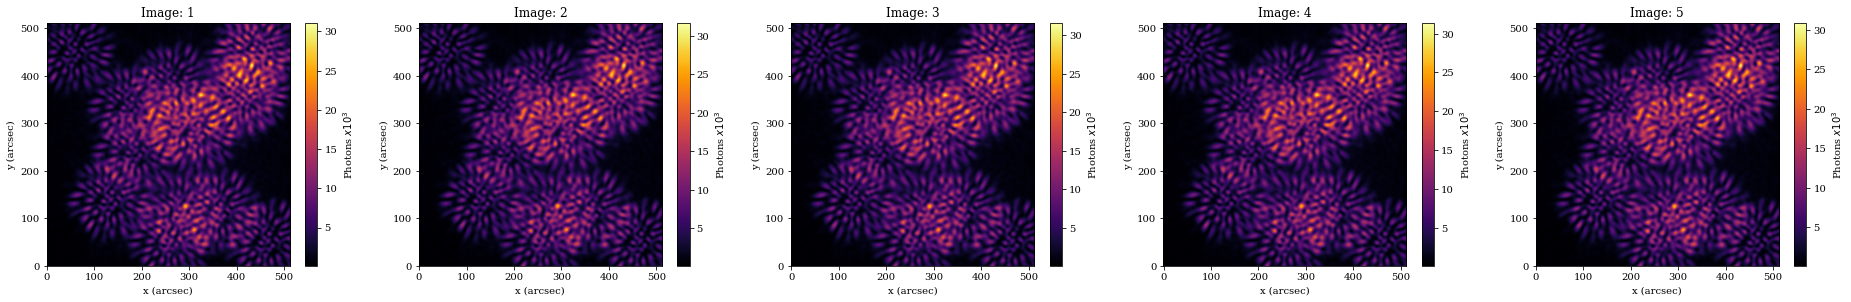

In [120]:
# Apply some noise to the PSF Background noise
data = jr.poisson(jr.PRNGKey(0), psfs)

plt.figure(figsize=(26, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.title(f"Image: {i+1}")
    plt.imshow(data[i] * 1e-3)
    plt.xlabel("x (arcsec)")
    plt.ylabel("y (arcsec)")
    plt.colorbar(label='Photons $x10^3$')
plt.tight_layout()
plt.show()

In [121]:
positions = 'source.position'
fluxes    = 'source.flux'
zernikes  = 'aperture.coefficients'
flatfield = 'ApplyPixelResponse.pixel_response'

parameters = [positions, fluxes, zernikes, flatfield]

In [122]:
# Add small random values to the positions
model = tel.add(positions, 2.*det_pixsize*jr.normal(jr.PRNGKey(0),  (Nstars, 2)))

# Multiply the fluxes by small random values
model = model.multiply(fluxes, 1 + 0.1*jr.normal(jr.PRNGKey(0), (Nstars,)))

# Set the zernike coefficients to zero
model = model.set(zernikes, np.zeros(model.get(zernikes).shape))

# Set the flat field to uniform
model = model.set(flatfield, np.ones((det_npix, det_npix)))

# Generate psfs
psfs = model.model()

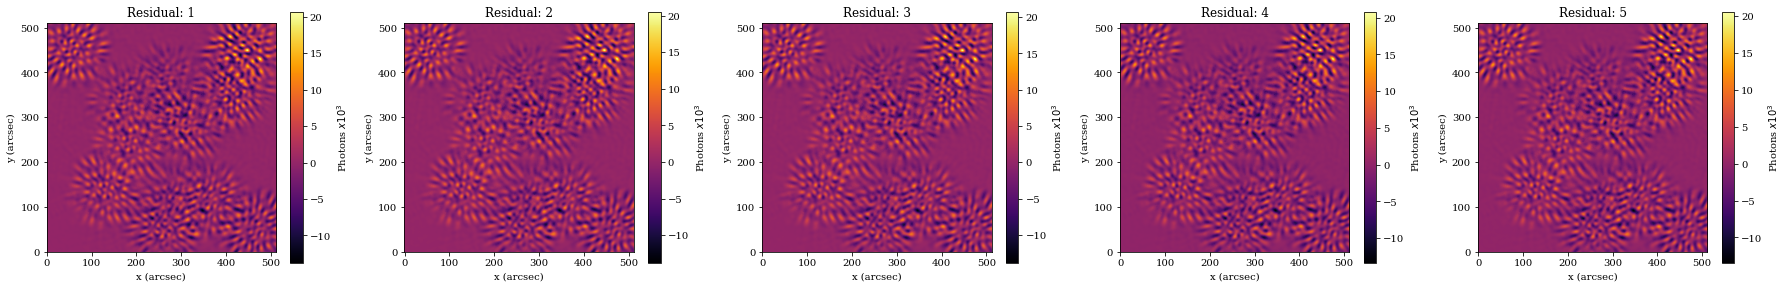

In [123]:
plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.title(f"Residual: {i+1}")
    plt.imshow((psfs[i] - data[i])*1e-3)
    plt.xlabel("x (arcsec)")
    plt.ylabel("y (arcsec)")
    plt.colorbar(label='Photons $x10^3$')
plt.tight_layout()
plt.show()

In [124]:
# So first we simply set the simple parameters to use an adam optimiser 
# algorithm, with individual learning rates
pos_optimiser   = optax.adam(1e-7)
flux_optimiser  = optax.adam(1e6)
coeff_optimiser = optax.adam(2e-9)

# Now the flat-field, because it is highly covariant with the mean flux level
# we don't start learning its parameters until the 100th epoch.
FF_sched = optax.piecewise_constant_schedule(init_value=1e-2*1e-8, 
                             boundaries_and_scales={100 : int(1e8)})
FF_optimiser = optax.adam(FF_sched)

# Combine the optimisers into a list
optimisers = [pos_optimiser, flux_optimiser, coeff_optimiser, FF_optimiser]

# Generate out optax optimiser, and also get our args
optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [125]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [126]:
%%time
loss, grads = loss_fn(model, data) # Compile
print("Initial Loss: {}".format(int(loss)))

Initial Loss: 816152896
CPU times: user 7.87 s, sys: 343 ms, total: 8.21 s
Wall time: 1.55 s


In [130]:
#from tqdm import tqdm
losses, models_out = [], []
with tqdm(range(200),desc='Gradient Descent') as t:
    for i in t: 
        print(i)
        loss, grads = loss_fn(model, data)    
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


Log Loss: 6.844: 100%|██████████| 200/200 [04:09<00:00,  1.25s/it]


In [131]:
nepochs = len(models_out)
psfs_out = models_out[-1].model()

positions_found  = np.array([model.get(positions) for model in models_out])
fluxes_found     = np.array([model.get(fluxes)    for model in models_out])
zernikes_found   = np.array([model.get(zernikes)  for model in models_out])
flatfields_found = np.array([model.get(flatfield) for model in models_out])

In [132]:
coeff_residuals = coeffs - zernikes_found
flux_residuals = true_fluxes - fluxes_found

scaler = 1e3
positions_residuals = true_positions - positions_found
r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
r_residuals = dlu.rad2arcsec(r_residuals_rads)

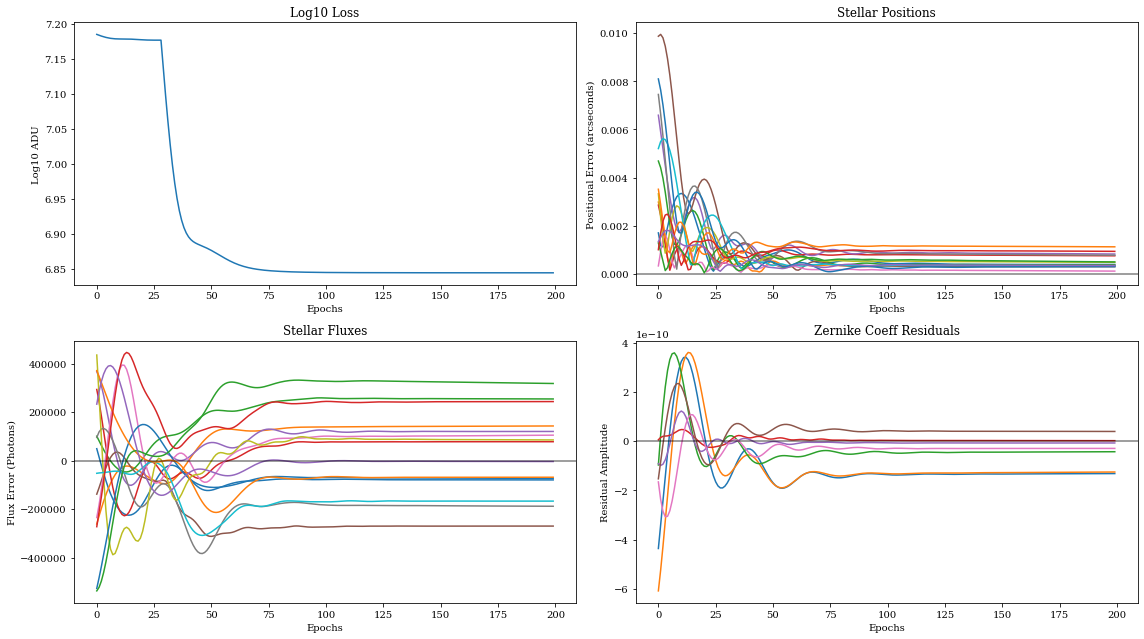

In [133]:
j = len(models_out)
plt.figure(figsize=(16, 13))

plt.subplot(3, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(np.array(losses)[:j]))

plt.subplot(3, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 3)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Zernike Coeff Residuals")
plt.xlabel("Epochs")
plt.ylabel("Residual Amplitude")
plt.plot(coeff_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

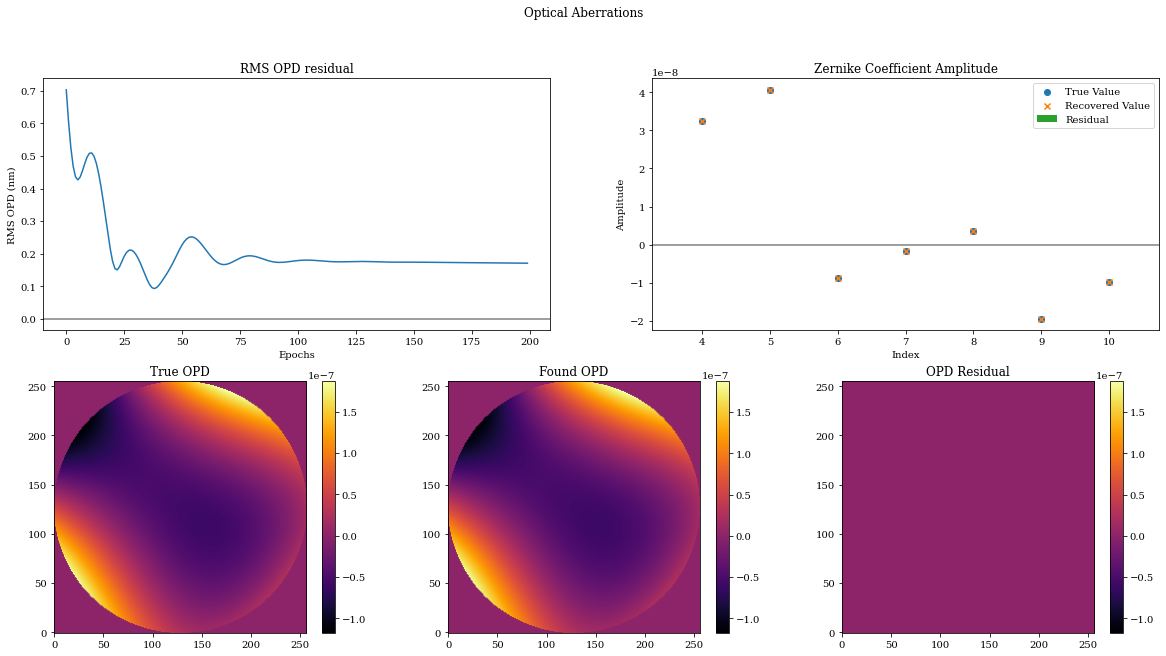

In [134]:
# OPDs
true_opd = tel.aperture.eval_basis()
opds_found = np.array([model.aperture.eval_basis() for model in models_out])
found_opd = opds_found[-1]
opd_residuls = true_opd - opds_found
opd_rmse_nm = 1e9*np.mean(opd_residuls**2, axis=(-1,-2))**0.5

vmin = np.min(np.array([true_opd, found_opd]))
vmax = np.max(np.array([true_opd, found_opd]))

# Coefficients
true_coeff = tel.get(zernikes)
found_coeff = models_out[-1].get(zernikes)
index = np.arange(len(true_coeff))+4

plt.figure(figsize=(20, 10))
plt.suptitle("Optical Aberrations")

plt.subplot(2, 2, 1)
plt.title("RMS OPD residual")
plt.xlabel("Epochs")
plt.ylabel("RMS OPD (nm)")
plt.plot(opd_rmse_nm)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(2, 2, 2)
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.scatter(index, true_coeff, label="True Value")
plt.scatter(index, found_coeff, label="Recovered Value", marker='x')
plt.bar(index, true_coeff - found_coeff, label='Residual')
plt.axhline(0, c='k', alpha=0.5)
plt.legend()

plt.subplot(2, 3, 4)
plt.title("True OPD")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found OPD")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("OPD Residual")
plt.imshow(true_opd - found_opd, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

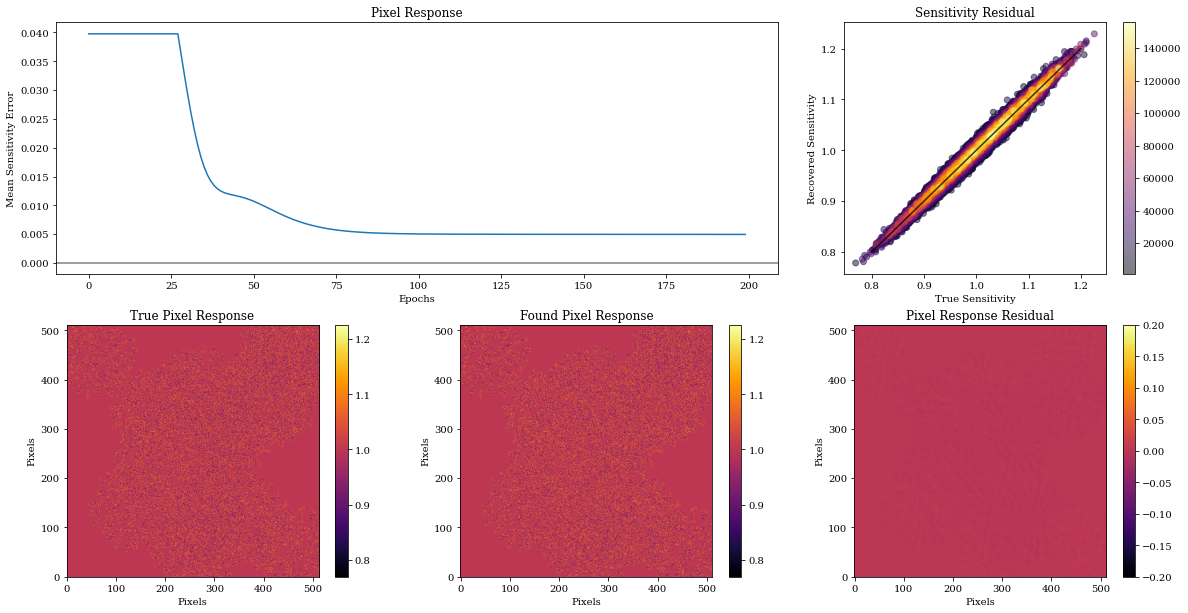

In [135]:
# calculate the mask where there was enough flux to infer the flat field
thresh = 2500
fmask = data.mean(0) >= thresh

out_mask = np.where(data.mean(0) < thresh)
in_mask = np.where(data.mean(0) >= thresh)

data_tile = np.tile(data.mean(0), [len(models_out), 1, 1])
in_mask_tiled = np.where(data_tile >= thresh)

# calculate residuals
pr_residuals = pix_response[in_mask] - flatfields_found[-1][in_mask]

# for correlation plot
true_pr_masked = pix_response.at[out_mask].set(1)
found_pr_masked = flatfields_found[-1].at[out_mask].set(1)

# FF Scatter Plot
data_sum = data.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

# Errors
pfound = flatfields_found[in_mask_tiled].reshape([len(models_out), len(in_mask[0])])
ptrue = pix_response[in_mask]
pr_res = ptrue - pfound
masked_error = np.abs(pr_res).mean(-1)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, (1,2))
plt.title("Pixel Response")
plt.xlabel("Epochs")
plt.ylabel("Mean Sensitivity Error")
plt.plot(masked_error)
plt.axhline(0, c='k', alpha=0.5)

# FF Scatter Plot
data_sum = data.sum(0)
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

plt.subplot(2, 3, 3)
plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
plt.scatter(pr_true_sort, pr_found_sort, c=colours, alpha=0.5)
plt.colorbar()
plt.title("Sensitivity Residual")
plt.ylabel("Recovered Sensitivity")
plt.xlabel("True Sensitivity")

plt.subplot(2, 3, 4)
plt.title("True Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked)
plt.colorbar()

vmin = np.min(pix_response)
vmax = np.max(pix_response)

plt.subplot(2, 3, 5)
plt.title("Found Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(found_pr_masked, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("Pixel Response Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked - found_pr_masked, vmin=-0.2, vmax=0.2)
plt.colorbar()

plt.show()

In [170]:
import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

def make_base_grid(npix, pixel_scale):
    indices = jnp.arange(npix)
    centers = (indices - (npix - 1) / 2) * pixel_scale
    return jnp.meshgrid(centers, centers)

def physical_to_indices(grid_x, grid_y, npix, pixel_scale):
    center = (npix - 1) / 2.0
    row = center + grid_y / pixel_scale
    col = center + grid_x / pixel_scale
    return jnp.stack([row, col], axis=0)

def sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale):
    coords = physical_to_indices(grid_x, grid_y, psf.shape[0], pixel_scale)
    return map_coordinates(psf, coords, order=1, mode='nearest')

def generate_true_shifts(npix, pixel_scale, shift_std, seed=42):
    key = jax.random.PRNGKey(seed)
    noise_x = jax.random.normal(key, (npix, npix))
    key, subkey = jax.random.split(key)
    noise_y = jax.random.normal(subkey, (npix, npix))
    shift_x_true = shift_std * noise_x
    shift_y_true = shift_std * noise_y
    return shift_x_true, shift_y_true

def generate_distorted_psf(psf, pixel_scale=0.375, shift_std_frac=0.01, seed=42):
    npix = psf.shape[0]
    shift_std = shift_std_frac * pixel_scale
    
    # Step 1: Make grid
    grid_x, grid_y = make_base_grid(npix, pixel_scale)

    # Step 2: Generate true per-pixel shifts
    shift_x_true, shift_y_true = generate_true_shifts(npix, pixel_scale, shift_std, seed=seed)

    # Step 3: Distort the grid
    distorted_x = grid_x - shift_x_true
    distorted_y = grid_y - shift_y_true

    # Step 4: Sample ideal PSF at distorted coordinates
    distorted_psf = sample_psf_on_distorted_grid(psf, distorted_x, distorted_y, pixel_scale)

    return distorted_psf, shift_x_true, shift_y_true


psf_npixels = 256
pixel_scale = 0.375
key = jax.random.PRNGKey(123)
pDistort = 1

# Assume you already have your PSF loaded as `psf`
distorted_psf, shift_x_true, shift_y_true = generate_distorted_psf(psf, pixel_scale=pixel_scale)

# Define parameter paths
shift_x_path = 'shift_x'
shift_y_path = 'shift_y'
parameters = [shift_x_path, shift_y_path]

# Define initial parameter guesses (after npix is known)
params = {
    "shift_x": jnp.zeros((psf_npixels, psf_npixels)),
    "shift_y": jnp.zeros((psf_npixels, psf_npixels)),
}

distorted_psf = jr.poisson(jr.PRNGKey(0), distorted_psf)



In [177]:
def model_fn(params):
    npix = psf.shape[0]
    grid_x, grid_y = make_base_grid(npix, pixel_scale)

    # Apply trainable shifts
    distorted_x = grid_x - params["shift_x"]
    distorted_y = grid_y - params["shift_y"]

    return sample_psf_on_distorted_grid(psf, distorted_x, distorted_y, pixel_scale)

def loss_fn(params):
    model_out = model_fn(params)
    return -jnp.sum(jax.scipy.stats.poisson.logpmf(distorted_psf, model_out))

optimizer = optax.adam(1e-2)
opt_state = optimizer.init(params)


In [174]:
%%time
loss, grads = jax.value_and_grad(loss_fn)(params)
print("Initial Loss:", float(loss))

Initial Loss: 157425.296875
CPU times: user 19.1 ms, sys: 5.72 ms, total: 24.9 ms
Wall time: 15.7 ms


In [175]:
@jax.jit
def step(params, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [178]:
from tqdm import tqdm

n_epochs = 2000
losses = []
params_out = []

for i in tqdm(range(n_epochs), desc="Gradient Descent"):
    params, opt_state, loss = step(params, opt_state)
    losses.append(loss)
    params_out.append(params)

    if i % 100 == 0:
        tqdm.write(f"Step {i}, Loss: {float(loss):.4f}")


Gradient Descent:  10%|█         | 201/2000 [00:00<00:03, 493.35it/s]

Step 0, Loss: 157424.6250
Step 100, Loss: 131136.4844
Step 200, Loss: 130641.9375
Step 300, Loss: 130539.9297


Gradient Descent:  30%|███       | 601/2000 [00:00<00:01, 1105.18it/s]

Step 400, Loss: 130508.3047
Step 500, Loss: 130488.8906
Step 600, Loss: 130480.4219
Step 700, Loss: 130469.8906


Gradient Descent:  50%|█████     | 1001/2000 [00:01<00:00, 1461.44it/s]

Step 800, Loss: 130468.0625
Step 900, Loss: 130460.0391
Step 1000, Loss: 130462.0234
Step 1100, Loss: 130460.0078


Gradient Descent:  70%|███████   | 1401/2000 [00:01<00:00, 1624.74it/s]

Step 1200, Loss: 130460.8828
Step 1300, Loss: 130473.2969
Step 1400, Loss: 130461.3750
Step 1500, Loss: 130459.8203


Gradient Descent:  90%|█████████ | 1800/2000 [00:01<00:00, 1786.98it/s]

Step 1600, Loss: 130462.5312
Step 1700, Loss: 130459.9844
Step 1800, Loss: 130459.8750
Step 1900, Loss: 130460.5469


Gradient Descent: 100%|██████████| 2000/2000 [00:01<00:00, 1300.01it/s]


Debugging Optimization Setup:
----------------------------------------
PSF Shape: (256, 256)
PSF Min/Max: 0.08892305195331573, 8093.50439453125
PSF Mean: 72.44989013671875

Observed Images:
Number of images: 5
Image Shape: (5, 256, 256)
Observed Images Min/Max: 0.0, 7843.0
Observed Images Mean: 72.40489959716797

Sample PSF Test:
Sample PSF Test Shape: (256, 256)
Sample PSF Test Min/Max: 0.14309623837471008, 5.726856708526611

Dithers:
Dithers Shape: (5, 2)
Dithers Values:
[[ 0.     0.   ]
 [ 0.075  0.075]
 [ 0.075 -0.075]
 [-0.075  0.075]
 [-0.075 -0.075]]

Grid:
Grid X Shape: (256, 256)
Grid Y Shape: (256, 256)


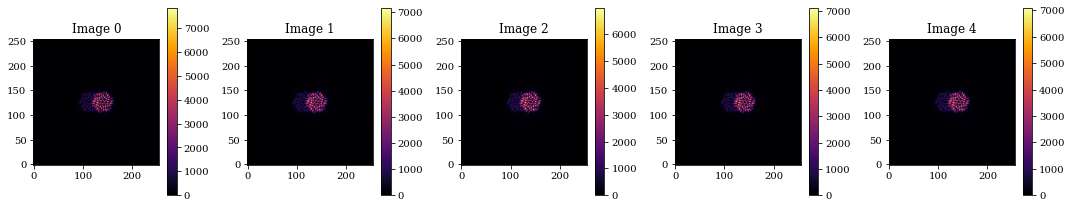


Training Diagnostics:


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Loss = 2.4139


/var/folders/s5/2h1mpzqd4yvdmq6dzdkqcpl40000gn/T/ipykernel_55834/3148800034.py:169: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  grad_norm = jnp.sqrt(sum((g**2).sum() for g in jax.tree_leaves(grads)))
Training:   1%|▏         | 73/5000 [00:01<01:17, 63.88it/s] 

Gradient Norm: 6.0264e-02


Training:   3%|▎         | 173/5000 [00:01<00:30, 157.10it/s]

Epoch 100: Loss = 2.3176
Gradient Norm: 6.6026e-03


Training:   6%|▌         | 277/5000 [00:02<00:18, 253.51it/s]

Epoch 200: Loss = 2.2977
Gradient Norm: 5.9215e-03


Training:   7%|▋         | 372/5000 [00:02<00:14, 309.71it/s]

Epoch 300: Loss = 2.2884
Gradient Norm: 6.1815e-03


Training:   9%|▉         | 471/5000 [00:02<00:13, 346.22it/s]

Epoch 400: Loss = 2.2827
Gradient Norm: 5.4621e-03


Training:  11%|█▏        | 572/5000 [00:02<00:11, 373.89it/s]

Epoch 500: Loss = 2.2791
Gradient Norm: 5.3244e-03


Training:  14%|█▎        | 675/5000 [00:03<00:11, 361.72it/s]

Epoch 600: Loss = 2.2765
Gradient Norm: 6.1244e-03


Training:  16%|█▌        | 776/5000 [00:03<00:10, 394.16it/s]

Epoch 700: Loss = 2.2746
Gradient Norm: 5.4344e-03


Training:  18%|█▊        | 877/5000 [00:03<00:10, 396.52it/s]

Epoch 800: Loss = 2.2732
Gradient Norm: 5.4594e-03


Training:  20%|█▉        | 977/5000 [00:04<00:09, 409.09it/s]

Epoch 900: Loss = 2.2722
Gradient Norm: 5.8611e-03


Training:  22%|██▏       | 1077/5000 [00:04<00:09, 416.52it/s]

Epoch 1000: Loss = 2.2713
Gradient Norm: 6.0309e-03


Training:  24%|██▎       | 1177/5000 [00:04<00:09, 420.64it/s]

Epoch 1100: Loss = 2.2706
Gradient Norm: 5.5378e-03


Training:  25%|██▌       | 1273/5000 [00:04<00:09, 411.03it/s]

Epoch 1200: Loss = 2.2701
Gradient Norm: 5.6119e-03


Training:  27%|██▋       | 1374/5000 [00:05<00:09, 402.40it/s]

Epoch 1300: Loss = 2.2696
Gradient Norm: 5.2888e-03


Training:  29%|██▉       | 1473/5000 [00:05<00:08, 402.38it/s]

Epoch 1400: Loss = 2.2692
Gradient Norm: 5.9057e-03


Training:  31%|███▏      | 1571/5000 [00:05<00:08, 392.30it/s]

Epoch 1500: Loss = 2.2688
Gradient Norm: 5.4249e-03


Training:  33%|███▎      | 1674/5000 [00:05<00:08, 401.58it/s]

Epoch 1600: Loss = 2.2686
Gradient Norm: 5.8347e-03


Training:  36%|███▌      | 1775/5000 [00:06<00:07, 404.78it/s]

Epoch 1700: Loss = 2.2683
Gradient Norm: 5.2732e-03


Training:  37%|███▋      | 1872/5000 [00:06<00:07, 394.67it/s]

Epoch 1800: Loss = 2.2681
Gradient Norm: 6.2306e-03


Training:  40%|███▉      | 1975/5000 [00:06<00:08, 372.56it/s]

Epoch 1900: Loss = 2.2679
Gradient Norm: 5.9910e-03


Training:  42%|████▏     | 2075/5000 [00:06<00:07, 394.96it/s]

Epoch 2000: Loss = 2.2678
Gradient Norm: 5.9118e-03


Training:  44%|████▎     | 2175/5000 [00:07<00:06, 405.20it/s]

Epoch 2100: Loss = 2.2676
Gradient Norm: 5.2806e-03


Training:  46%|████▌     | 2275/5000 [00:07<00:06, 408.76it/s]

Epoch 2200: Loss = 2.2675
Gradient Norm: 5.9387e-03


Training:  48%|████▊     | 2376/5000 [00:07<00:06, 403.66it/s]

Epoch 2300: Loss = 2.2674
Gradient Norm: 6.3223e-03


Training:  50%|████▉     | 2476/5000 [00:07<00:06, 410.69it/s]

Epoch 2400: Loss = 2.2673
Gradient Norm: 5.7503e-03


Training:  51%|█████▏    | 2569/5000 [00:08<00:06, 397.85it/s]

Epoch 2500: Loss = 2.2672
Gradient Norm: 5.4607e-03


Training:  54%|█████▎    | 2675/5000 [00:08<00:05, 412.21it/s]

Epoch 2600: Loss = 2.2671
Gradient Norm: 5.9270e-03


Training:  55%|█████▌    | 2772/5000 [00:08<00:05, 400.00it/s]

Epoch 2700: Loss = 2.2670
Gradient Norm: 5.4757e-03


Training:  57%|█████▋    | 2872/5000 [00:09<00:05, 391.80it/s]

Epoch 2800: Loss = 2.2670
Gradient Norm: 5.7591e-03


Training:  59%|█████▉    | 2963/5000 [00:09<00:05, 370.80it/s]

Epoch 2900: Loss = 2.2669
Gradient Norm: 5.0282e-03


Training:  61%|██████    | 3052/5000 [00:09<00:05, 344.08it/s]

Epoch 3000: Loss = 2.2669
Gradient Norm: 5.6919e-03


Training:  64%|██████▎   | 3176/5000 [00:09<00:04, 368.26it/s]

Epoch 3100: Loss = 2.2668
Gradient Norm: 5.9548e-03


Training:  66%|██████▌   | 3275/5000 [00:10<00:04, 393.46it/s]

Epoch 3200: Loss = 2.2668
Gradient Norm: 6.0665e-03


Training:  68%|██████▊   | 3375/5000 [00:10<00:03, 406.35it/s]

Epoch 3300: Loss = 2.2667
Gradient Norm: 5.9830e-03


Training:  70%|██████▉   | 3475/5000 [00:10<00:03, 412.42it/s]

Epoch 3400: Loss = 2.2667
Gradient Norm: 5.9966e-03


Training:  71%|███████▏  | 3573/5000 [00:10<00:03, 408.45it/s]

Epoch 3500: Loss = 2.2667
Gradient Norm: 5.5183e-03


Training:  73%|███████▎  | 3672/5000 [00:11<00:03, 395.98it/s]

Epoch 3600: Loss = 2.2667
Gradient Norm: 5.5796e-03


Training:  76%|███████▌  | 3775/5000 [00:11<00:03, 403.54it/s]

Epoch 3700: Loss = 2.2666
Gradient Norm: 5.4965e-03


Training:  78%|███████▊  | 3875/5000 [00:11<00:02, 406.28it/s]

Epoch 3800: Loss = 2.2666
Gradient Norm: 5.7826e-03


Training:  79%|███████▉  | 3972/5000 [00:12<00:02, 396.57it/s]

Epoch 3900: Loss = 2.2666
Gradient Norm: 5.3414e-03


Training:  82%|████████▏ | 4075/5000 [00:12<00:02, 400.63it/s]

Epoch 4000: Loss = 2.2666
Gradient Norm: 5.8869e-03


Training:  83%|████████▎ | 4172/5000 [00:12<00:02, 402.03it/s]

Epoch 4100: Loss = 2.2666
Gradient Norm: 6.0108e-03


Training:  85%|████████▌ | 4254/5000 [00:12<00:02, 348.95it/s]

Epoch 4200: Loss = 2.2665
Gradient Norm: 5.6398e-03


Training:  87%|████████▋ | 4373/5000 [00:13<00:01, 365.36it/s]

Epoch 4300: Loss = 2.2665
Gradient Norm: 6.0863e-03


Training:  89%|████████▉ | 4473/5000 [00:13<00:01, 382.52it/s]

Epoch 4400: Loss = 2.2665
Gradient Norm: 5.3419e-03


Training:  91%|█████████▏| 4564/5000 [00:13<00:01, 368.38it/s]

Epoch 4500: Loss = 2.2665
Gradient Norm: 5.6046e-03


Training:  93%|█████████▎| 4672/5000 [00:14<00:00, 388.91it/s]

Epoch 4600: Loss = 2.2665
Gradient Norm: 5.9598e-03


Training:  95%|█████████▌| 4773/5000 [00:14<00:00, 390.94it/s]

Epoch 4700: Loss = 2.2665
Gradient Norm: 6.0633e-03


Training:  97%|█████████▋| 4872/5000 [00:14<00:00, 389.12it/s]

Epoch 4800: Loss = 2.2665
Gradient Norm: 5.1535e-03


Training: 100%|██████████| 5000/5000 [00:14<00:00, 334.38it/s]

Epoch 4900: Loss = 2.2665
Gradient Norm: 5.6014e-03


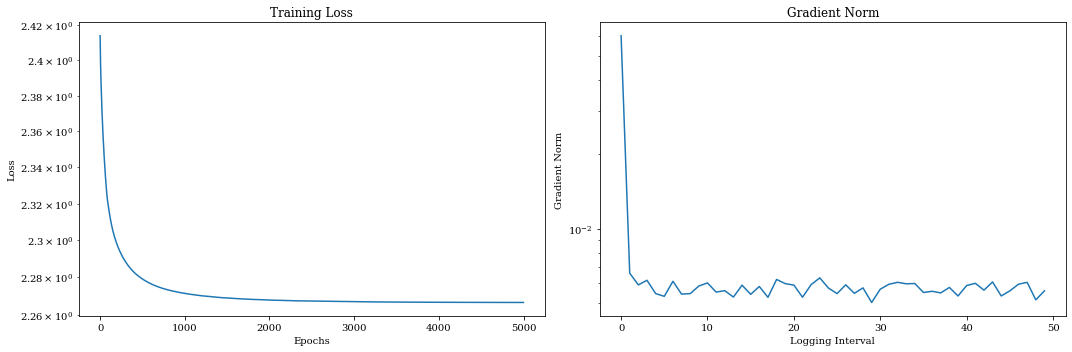


Final Estimated Shifts:
Shift X:
[[ 9.0957720e-08 -2.7626622e-01  6.0125190e-01 ... -6.0821474e-01
   7.5010858e-02 -8.3053708e-02]
 [-2.7209871e-06  1.0678551e-01 -7.5002305e-02 ...  3.0000320e-01
   3.7500200e-01  1.4491377e-05]
 [-1.5038070e-02  4.5103765e-01 -7.5004168e-02 ...  7.5003996e-02
  -2.9999411e-01 -7.7125303e-02]
 ...
 [-2.8980300e-01 -3.0000070e-01 -6.3292198e-02 ...  7.5006843e-02
   3.0000636e-01  7.5007670e-02]
 [ 8.4366880e-02 -7.5003415e-02 -1.4377598e-05 ...  6.0763043e-01
   9.0914392e-01  7.5005695e-02]
 [ 8.5232787e-02 -7.5001344e-02  4.5000187e-01 ...  2.8765041e-01
   6.1170644e-01 -8.3474360e-02]]

True Shift X:
[[-0.00915921 -0.0076338   0.00077079 ... -0.00148686  0.00121724
   0.00311946]
 [ 0.00041834  0.00300814  0.00197756 ...  0.00410414 -0.00061901
  -0.00054695]
 [-0.00019942  0.00753802  0.00272312 ...  0.00101623 -0.004469
  -0.00542333]
 ...
 [ 0.00431632 -0.00332927 -0.00166085 ...  0.00330636 -0.00120926
   0.00262065]
 [ 0.00311556  0.0001196

In [30]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy.ndimage import map_coordinates
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt

# Comprehensive Debugging Function
def debug_optimization_setup(psf, observed_images, grid_x, grid_y, pixel_scale, dithers):
    """
    Perform comprehensive diagnostics on the optimization setup
    """
    print("Debugging Optimization Setup:")
    print("-" * 40)
    
    # Check PSF characteristics
    print(f"PSF Shape: {psf.shape}")
    print(f"PSF Min/Max: {psf.min()}, {psf.max()}")
    print(f"PSF Mean: {psf.mean()}")
    
    # Check observed images
    print("\nObserved Images:")
    print(f"Number of images: {len(observed_images)}")
    print(f"Image Shape: {observed_images.shape}")
    print(f"Observed Images Min/Max: {observed_images.min()}, {observed_images.max()}")
    print(f"Observed Images Mean: {observed_images.mean()}")
    
    # Sample PSF test
    print("\nSample PSF Test:")
    try:
        test_dither = dithers[0]
        dx = (grid_x + test_dither[0])
        dy = (grid_y + test_dither[1])
        sample_test = map_coordinates(psf, jnp.stack([dx, dy], axis=0), order=1, mode="nearest")
        print(f"Sample PSF Test Shape: {sample_test.shape}")
        print(f"Sample PSF Test Min/Max: {sample_test.min()}, {sample_test.max()}")
    except Exception as e:
        print(f"Sample PSF Test Failed: {e}")
    
    # Dithers check
    print("\nDithers:")
    print(f"Dithers Shape: {dithers.shape}")
    print(f"Dithers Values:\n{dithers}")
    
    # Grid check
    print("\nGrid:")
    print(f"Grid X Shape: {grid_x.shape}")
    print(f"Grid Y Shape: {grid_y.shape}")
    
    # Visualization of first few images
    plt.figure(figsize=(15, 3))
    for i in range(min(5, len(observed_images))):
        plt.subplot(1, 5, i+1)
        plt.imshow(observed_images[i])
        plt.title(f"Image {i}")
        plt.colorbar()
    plt.tight_layout()
    plt.show()

# Poisson Loss with Numerical Stability
def poisson_loss(preds, observed):
    """
    Compute Poisson log-likelihood loss with numerical stability
    """
    # Ensure inputs are float32
    preds = jnp.asarray(preds, dtype=jnp.float32)
    observed = jnp.asarray(observed, dtype=jnp.float32)
    
    # Add small epsilon to prevent log(0)
    epsilon = 1e-10
    safe_preds = jnp.maximum(preds, epsilon)
    
    # Compute log-likelihood
    log_likelihood = observed * jnp.log(safe_preds) - safe_preds - jax.lax.lgamma(observed + 1)
    
    return -jnp.mean(log_likelihood)

# Comprehensive Forward Model
def model_fn(params, psf, grid_x, grid_y, pixel_scale, dithers):
    out = []
    for d in dithers:
        dx = (grid_x + d[0]) - params["shift_x"]
        dy = (grid_y + d[1]) - params["shift_y"]
        
        # Ensure coordinates are in the correct range
        center = (psf.shape[0] - 1) / 2.0
        row_idx = center + dy / pixel_scale
        col_idx = center + dx / pixel_scale
        
        coords = jnp.stack([row_idx, col_idx], axis=0)
        
        # Sample with interpolation and mode handling
        sim = map_coordinates(psf, coords, order=1, mode="nearest")
        out.append(sim)
    
    return jnp.stack(out)

# Diagnostic Training Function
def train_with_diagnostics(psf, observed_images, grid_x, grid_y, pixel_scale, dithers):
    # First, run comprehensive debug
    debug_optimization_setup(psf, observed_images, grid_x, grid_y, pixel_scale, dithers)
    
    # Configuration
    npix = psf.shape[0]
    shift_std = 0.01 * pixel_scale
    n_epochs = 5000
    
    # Initialization with careful scaling
    key = jr.PRNGKey(0)
    key, kx, ky = jr.split(key, 3)
    
    # Loss Function
    def loss_fn(params):
        preds = model_fn(
            params, 
            psf=psf, 
            grid_x=grid_x, 
            grid_y=grid_y, 
            pixel_scale=pixel_scale, 
            dithers=dithers
        )
        return poisson_loss(preds, observed_images)
    
    # Advanced Optimizer with Learning Rate Schedule
    lr_schedule = optax.exponential_decay(
        init_value=1e-3,     # Initial learning rate
        transition_steps=100, # Decay every 100 steps
        decay_rate=0.9        # Decay by 10% each time
    )
    
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),  # Gradient clipping
        optax.adam(lr_schedule)
    )
    
    # Initial Parameters with Careful Scaling
    params = {
        "shift_x": jr.normal(kx, (npix, npix)) * shift_std * 0.01,
        "shift_y": jr.normal(ky, (npix, npix)) * shift_std * 0.01,
    }
    opt_state = optimizer.init(params)
    
    # Training Loop with Extensive Logging
    @jax.jit
    def step(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    
    # Tracking
    losses = []
    grad_norms = []
    
    print("\nTraining Diagnostics:")
    for i in tqdm(range(n_epochs), desc="Training"):
        params, opt_state, loss_val = step(params, opt_state)
        
        # Track losses and gradient norms
        losses.append(loss_val)
        
        # Periodic logging
        if i % 100 == 0:
            print(f"Epoch {i}: Loss = {loss_val:.4f}")
            
            # Compute gradient norms for debugging
            _, grads = jax.value_and_grad(loss_fn)(params)
            grad_norm = jnp.sqrt(sum((g**2).sum() for g in jax.tree_leaves(grads)))
            grad_norms.append(grad_norm)
            print(f"Gradient Norm: {grad_norm:.4e}")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.plot(grad_norms)
    plt.title('Gradient Norm')
    plt.xlabel('Logging Interval')
    plt.ylabel('Gradient Norm')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return params, losses

# Run the diagnostic training
result_params, result_losses = train_with_diagnostics(
    psf, observed_images, grid_x, grid_y, pixel_scale, dithers
)

# Final Parameter Comparison
print("\nFinal Estimated Shifts:")
print("Shift X:")
print(result_params["shift_x"])
print("\nTrue Shift X:")
print(true_shift_x)

print("\nShift Y:")
print(result_params["shift_y"])
print("\nTrue Shift Y:")
print(true_shift_y)


Mean Absolute Error (X): 1.67770e-01
Mean Absolute Error (Y): 1.71049e-01


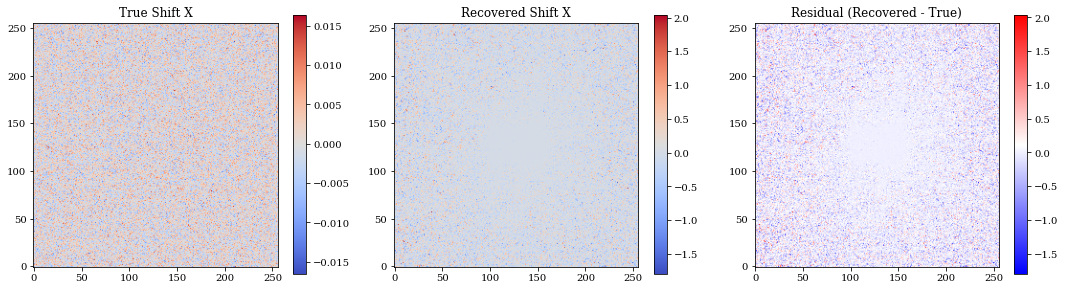

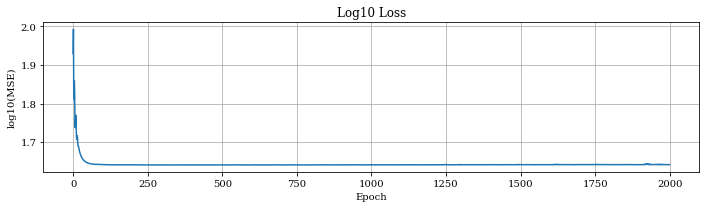

In [23]:

# --- Evaluation ---
recovered_x = params["shift_x"]
recovered_y = params["shift_y"]

mae_x = jnp.mean(jnp.abs(recovered_x - true_shift_x))
mae_y = jnp.mean(jnp.abs(recovered_y - true_shift_y))
print(f"Mean Absolute Error (X): {mae_x:.5e}")
print(f"Mean Absolute Error (Y): {mae_y:.5e}")

# --- Plots ---
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("True Shift X")
plt.imshow(true_shift_x, cmap="coolwarm")
plt.colorbar()

plt.subplot(132)
plt.title("Recovered Shift X")
plt.imshow(recovered_x, cmap="coolwarm")
plt.colorbar()

plt.subplot(133)
plt.title("Residual (Recovered - True)")
plt.imshow(recovered_x - true_shift_x, cmap="bwr")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(jnp.log10(jnp.array(losses)))
plt.title("Log10 Loss")
plt.xlabel("Epoch")
plt.ylabel("log10(MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 0, Loss =  150369.953125
Epoch 20, Loss =  155025.765625
Epoch 40, Loss =  134425.953125
Epoch 60, Loss =  135610.312500
Epoch 80, Loss =  126971.632812
Epoch 100, Loss =  173508.140625
Epoch 120, Loss =  160141.187500
Epoch 140, Loss =  170999.796875
Epoch 160, Loss =  168721.781250
Epoch 180, Loss =  166665.093750
Epoch 200, Loss =  166269.953125
Epoch 220, Loss =  166999.093750
Epoch 240, Loss =  166273.703125
Epoch 260, Loss =  163766.062500
Epoch 280, Loss =  162395.828125
Epoch 300, Loss =  159956.328125
Epoch 320, Loss =  159956.328125
Epoch 340, Loss =  159956.328125
Epoch 360, Loss =  159956.328125
Epoch 380, Loss =  159956.328125
Epoch 400, Loss =  159956.328125
Epoch 420, Loss =  159956.328125
Epoch 440, Loss =  159956.328125
Epoch 460, Loss =  159956.328125
Epoch 480, Loss =  159956.328125
Epoch 500, Loss =  159956.328125
Epoch 520, Loss =  159956.328125
Epoch 540, Loss =  159956.328125
Epoch 560, Loss =  159956.328125
Epoch 580, Loss =  159956.328125
Epoch 600, Loss 

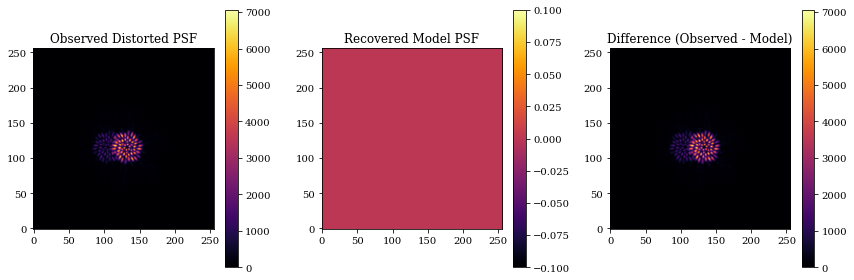

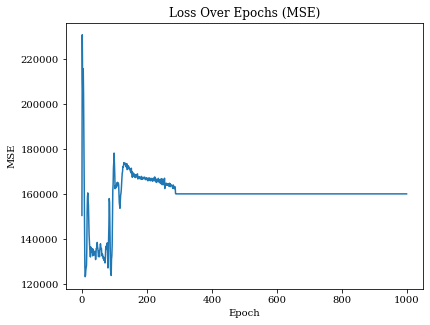

In [19]:
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import matplotlib.pyplot as plt

###############################################################################
# 1) Generate polynomial exponents up to a chosen total order
###############################################################################
def gen_powers(order: int):
    """
    Enumerates all pairs (xpows[i], ypows[i]) for x^i y^j
    with i + j <= order. For example:

    order=2 -> 6 terms total:
      (0,0), (1,0), (0,1), (2,0), (1,1), (0,2)

    Returns xpows, ypows as 1D arrays of length n_terms.
    """
    xpows = []
    ypows = []
    for total in range(order + 1):
        for i in range(total + 1):
            j = total - i
            xpows.append(i)
            ypows.append(j)
    return jnp.array(xpows), jnp.array(ypows)


###############################################################################
# 2) Distort a coordinate grid with a global 2D polynomial
###############################################################################
def distort_coords(coords, coeffs, xpows, ypows):
    """
    coords: shape (2, H, W), coords[0]=x, coords[1]=y
    coeffs: shape (2, n_terms) => polynomial coeffs for x-dist & y-dist
    xpows, ypows: (n_terms,)

    Returns new_coords of shape (2, H, W):
      new_x = x + sum_i coeffs[0, i] * x^xpows[i] * y^ypows[i]
      new_y = y + sum_i coeffs[1, i] * x^xpows[i] * y^ypows[i]
    """
    x = coords[0]
    y = coords[1]
    n_terms = coeffs.shape[1]

    # Build polynomial basis => shape (n_terms, H, W)
    basis = jnp.stack([x**xpows[i] * y**ypows[i] for i in range(n_terms)], axis=0)

    # Weighted sum for x-distortion
    delta_x = jnp.sum(coeffs[0, :, None, None] * basis, axis=0)
    # Weighted sum for y-distortion
    delta_y = jnp.sum(coeffs[1, :, None, None] * basis, axis=0)

    return jnp.stack([x + delta_x, y + delta_y], axis=0)


###############################################################################
# 3) Bilinear interpolation for a 2D image at float coords
###############################################################################
def bilinear_interpolate(image, x, y):
    """
    image: shape (H, W)
    x, y: shape (H, W), specifying the coordinates from which we sample `image`.
    Returns warped image of shape (H, W).
    """
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # Clip to image boundaries
    x0 = jnp.clip(x0, 0, image.shape[1] - 1)
    x1 = jnp.clip(x1, 0, image.shape[1] - 1)
    y0 = jnp.clip(y0, 0, image.shape[0] - 1)
    y1 = jnp.clip(y1, 0, image.shape[0] - 1)

    Ia = image[y0, x0]
    Ib = image[y0, x1]
    Ic = image[y1, x0]
    Id = image[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)

    return Ia*wa + Ib*wb + Ic*wc + Id*wd


###############################################################################
# 4) Build a coordinate grid from -0.5..+0.5 (similar to dLux pixel_coords)
###############################################################################
def pixel_coords(n, diameter=1.0):
    """
    Returns shape (2, n, n): a grid from roughly [-diameter/2..+diameter/2]
    with step ~ diameter/n. coords[0]=x, coords[1]=y.
    """
    step = diameter / n
    half = diameter / 2
    # e.g. for n=128, diameter=1 => x in [-0.5..+0.5)
    x1d = jnp.linspace(-half + step/2, half - step/2, n)
    X, Y = jnp.meshgrid(x1d, x1d)
    return jnp.stack([X, Y], axis=0)


###############################################################################
# 5) "Forward model": Given polynomial coeffs, warp an "ideal" PSF
###############################################################################
def forward_model(coeffs, psf, xpows, ypows):
    """
    coeffs: shape (2, n_terms)
    psf: shape (H,W)
    xpows, ypows: exponents

    Steps:
     1) Build coords in [-0.5..+0.5].
     2) Distort them with the polynomial.
     3) Interpolate the psf at these new coords.
    """
    H, W = psf.shape
    coords = pixel_coords(H, diameter=1.0)
    # Distort
    newcoords = distort_coords(coords, coeffs, xpows, ypows)

    # Convert newcoords from [-0.5..+0.5] to [0..H or W] for indexing
    x_index = (newcoords[0] + 0.5) * H
    y_index = (newcoords[1] + 0.5) * W

    # Interpolate
    return bilinear_interpolate(psf, x_index, y_index)


###############################################################################
# 6) MSE loss: measure difference between "observed" and "model"
###############################################################################
def mse_loss(coeffs, psf, xpows, ypows, observed):
    """
    Return MSE over all pixels: mean((obs - model)^2).
    """
    pred = forward_model(coeffs, psf, xpows, ypows)
    return jnp.mean((observed - pred)**2)


###############################################################################
# 7) Main script: create a distorted PSF, then recover the polynomial coefficients
###############################################################################

key = jr.PRNGKey(0)

#---------------------------------------------------------------------------
# A) Build a synthetic "ideal PSF" (2D Gaussian)
#---------------------------------------------------------------------------
size = 256

#---------------------------------------------------------------------------
# B) Pick "true" polynomial coeffs, warp the PSF -> "observed data"
#---------------------------------------------------------------------------
order = 3  # let's say up to total polynomial order 3 => 10 terms
xpows, ypows = gen_powers(order)
n_terms = xpows.shape[0]

# Suppose the "true" X-dist, Y-dist are random small expansions
true_coeffs = 0.02 * jr.normal(key, (2, n_terms))

# Distort the ideal PSF
coords = pixel_coords(size, 1.0)
newcoords = distort_coords(coords, true_coeffs, xpows, ypows)
x_index = (newcoords[0] + 0.5) * size
y_index = (newcoords[1] + 0.5) * size
distorted_psf = bilinear_interpolate(psf, x_index, y_index)

# We'll treat "distorted_psf" as the observed data.
# Optionally you could add noise if desired:
#   key, subkey = jr.split(key)
#   observed_data = jr.normal(subkey, shape=distorted_psf.shape)*some_sigma + distorted_psf
# But for clarity we'll skip noise.

observed_data = distorted_psf

#---------------------------------------------------------------------------
# C) We want to retrieve the polynomial coefficients by MSE minimization
#---------------------------------------------------------------------------
# 1) Initialize guess => zeros
guess_coeffs = jnp.zeros_like(true_coeffs)

# 2) Create an optimizer
lr = 1e-1
optimizer = optax.adam(lr)
opt_state = optimizer.init(guess_coeffs)

# 3) Single-step function
@jax.jit
def step_fn(params, opt_state):
    loss_val, grads = jax.value_and_grad(mse_loss)(
        params, psf, xpows, ypows, observed_data
    )
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss_val

# 4) Run the training loop
n_epochs = 1000
losses = []
coeffs = guess_coeffs
for i in range(n_epochs):
    coeffs, opt_state, loss_val = step_fn(coeffs, opt_state)
    losses.append(loss_val)
    if i % 20 == 0:
        print(f"Epoch {i}, Loss = {loss_val: .6f}")

final_loss = losses[-1]
print("Final Loss:", final_loss)

#---------------------------------------------------------------------------
# Compare recovered coefficients to the "true" polynomial
#---------------------------------------------------------------------------
diff = coeffs - true_coeffs
mae = jnp.abs(diff).mean()
print("Mean absolute error in polynomial coefficients:", mae)

# Construct final model image from the fitted polynomial
final_psf = forward_model(coeffs, psf, xpows, ypows)

#---------------------------------------------------------------------------
# Visualize
#---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title("Observed Distorted PSF")
plt.imshow(observed_data, origin="lower")
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Recovered Model PSF")
plt.imshow(final_psf, origin="lower")
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Difference (Observed - Model)")
plt.imshow(observed_data - final_psf, origin="lower")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.title("Loss Over Epochs (MSE)")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

